In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector, Operator
from scipy.interpolate import UnivariateSpline
from qiskit_ibm_runtime.fake_provider import FakeManilaV2 # Retired quantum processor
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService


In [2]:
import sys
import os

In [3]:
backend_name = "aer" #manila, aer
trotter_order= "second" #first, second

In [4]:
import qiskit 
qiskit.version.get_version_info() 

'1.1.1'

In [5]:
import qiskit_ibm_runtime 
qiskit_ibm_runtime .version.get_version_info() 

'0.24.1'

In [6]:

#ionq backend start
from qiskit import transpile

# Load the API key from the environment variable
api_key = os.getenv('IONQ_API_KEY')
from qiskit_ionq import IonQProvider
# api_key = "zneojFDA2Je63szoO1GYFi7EwQO9FEnQ"
api_key = "dyqcuoaSoGAdBGbuxj05KL4zvK4OU2Np" #for project csc-500
provider = IonQProvider(api_key)
print(provider.backends())

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]


In [7]:
# Determine the correct path for the 'src' directory
if '__file__' in globals():
    # Running as a script
    src_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'src'))
else:
    # Running in an interactive environment like Jupyter Notebook
    src_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

sys.path.append(src_dir)

In [8]:

from hamiltonian import construct_hamiltonian
from evolve import evolve_and_measure_circuit
from meas_counts import meas_counts
from sigma_statistics import calc_mean_and_sigma
from constants import hbar, c , eV, MeV, GeV, G_F, kB

In [9]:
def initialize_parameters():
    N_sites = 4 # Number of qubits
    delta_m_squared = 0.5 # change accordingly with the desired Rog fit reproduction below 
    omega_a = np.full(N_sites // 2, delta_m_squared)
    omega_b = np.zeros(N_sites // 2)
    omega = np.concatenate((omega_a, omega_b))
    print(omega)
    shots = 1024
    trotter_steps= 10 # Number of Trotter steps per time step
    optimization_level = 1
    if backend_name == 'manila':
        backend = FakeManilaV2()
    elif backend_name == 'aer':
        backend = AerSimulator(method='automatic')
        # backend = AerSimulator(method='matrix_product_state')
        # Configure backend options for matrix product state simulation
        # backend.set_options(
        #     matrix_product_state_max_bond_dimension=1000,  #  (int): Sets a limit on the number of Schmidt coefficients retained at the end of the svd algorithm. Coefficients beyond this limit will be discarded. # (Default: None, i.e., no limit on the bond dimension).
        #     matrix_product_state_truncation_threshold=1e-100,  # (double): Discard the smallest coefficients for which the sum of their squares is smaller than this threshold. (Default: 1e-16).
        #     mps_sample_measure_algorithm="mps_apply_measure",  # (str): Choose between "mps_apply_measure" and "mps_probabilities" consult https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.AerSimulator.html before choosing
        #     mps_log_data=True,  # if True, output logging data of the MPS structure: bond dimensions and values discarded during approximation. (Default: False)
        #     mps_swap_direction="mps_swap_right",  # (str): Determine the direction of swapping the qubits when internal swaps are inserted for a 2-qubit gate. Possible values are “mps_swap_right” and “mps_swap_left”. (Default: “mps_swap_left”)
        #     chop_threshold=1e-8,  # (float): This option sets a threshold for truncating snapshots (Default: 1e-8).
        #     mps_parallel_threshold=14,  # (int): This option sets OMP number threshold (Default: 14).
        #     mps_omp_threads=1,  #  (int): This option sets the number of OMP threads (Default: 1).
        #     # mps_omp_threads=int(os.environ["OMP_NUM_THREADS"]),  # Use all available cores
        #     mps_lapack=True  # (bool): This option indicates to compute the SVD function using OpenBLAS/Lapack interface (Default: False).
        # )
    elif backend_name == 'ibm':
        # Define the service to access IBM Quantum systems.
        service = QiskitRuntimeService()
        backend = service.least_busy(operational=True, simulator=False)
    elif backend_name == 'ionq_qpu':
            backend = provider.get_backend("ionq_qpu.forte-1") # qpu.aria-1 # qpu.aria-2 #qpu.forte-1 whichever one is available
    elif backend_name == 'ionq_native': 
            backend = provider.get_backend("simulator", gateset="native")
    elif backend_name == 'ionq_noisy_sim':
            backend = provider.get_backend("simulator")
            backend.set_options(noise_model="aria-1") # aria-1, forte-1, aria-2
    elif backend_name == 'ionq': 
            backend = provider.get_backend("simulator")

        
    tolerance = 5e-1
    τ = 0.05  # Time step
    ttotal = 10  # Total time
    times = np.arange(0, τ + ttotal , τ)  # Define time steps
    Δx = 1E-3 # length of the box of interacting neutrinos at a site in cm #variable
    L = 1 # cm # not being used in this test but defined to keep the evolve function arguments consistent.
    Δp = L # width of shape function # not being used in this test but defined to keep the evolve function arguments consistent.
    t1 = 0.0084003052 #choose initial time for growth rate calculation #variable, not being used in this test
    t2 = 0.011700318 #choose final time for growth rate calculation #variable, not being used in this test
    theta_nu = 0 # mixing_angle #rad 
    # Initialize an array of zeros for all N_sites particles
    # mu = np.ones(N_sites)
    mu = 1
    # Create an array of dimension N and fill it with the value 1/(sqrt(2) * G_F). This is the number of neutrinos.
    N = mu * np.full(N_sites, (Δx**3) / (np.sqrt(2) * G_F *N_sites))

    # Create a B vector which would be same for all N particles
    B = np.array([np.sin(2 * theta_nu), 0, -np.cos(2 * theta_nu)])
    B = B / np.linalg.norm(B)

    # Generate x, y, and z arrays
    x = np.random.rand(N_sites)
    y = np.random.rand(N_sites)
    z = np.zeros(N_sites)
    
    def generate_p_array(N_sites):
        half_N_sites = N_sites // 2
        p_array = np.concatenate((np.full(half_N_sites, 1), np.full(half_N_sites, 1)))
        return p_array

    p_array = generate_p_array(N_sites)

    # Create the p matrix with numbers generated from the p_array for the first component and zeros for the other components (x, y, z)
    p = np.column_stack((p_array, np.zeros(N_sites), np.zeros(N_sites)))

    # All of the sites are neutrinos, energy_sign array
    energy_sign = np.ones(N_sites)
    #modify this shape_name dict thing
    shape_name = 1  # variable.  #Select a shape function based on the shape_name variable form the list defined in dictionary in shape_func file

    return N_sites, theta_nu, omega, B, N, x, p, energy_sign, Δx, Δp, L, delta_m_squared, shape_name , shots, trotter_steps, backend, tolerance, τ, times, ttotal, optimization_level


In [10]:

def simulate(times, omega, N_sites, theta_nu, backend, shots, τ, ttotal,optimization_level,N, B, Δx, p, tolerance, trotter_steps, trotter_order):
    # Simulation and expected value calculation
    sigma_z_values = []
    survival_probabilities = []

    for t in times:
        if backend_name == 'aer':
            counts_z, isa_circuit_z, density_matrix = meas_counts(t, N, omega, B, N_sites, Δx,  p,theta_nu, trotter_steps, trotter_order, 'Z', backend_name, backend,optimization_level, shots)
        else:
            counts_z, isa_circuit_z = meas_counts(t, N, omega, B, N_sites, Δx,  p,theta_nu, trotter_steps, trotter_order, 'Z', backend_name, backend,optimization_level, shots)
        sigma_z, std_sigma_z = calc_mean_and_sigma(counts_z, shots, 'Z')
        
        # Calculate survival probability
        survival_probability = (1 - sigma_z) / 2
        print(f"t: {t}, survival_probability: {survival_probability}")
        
        # Append values to the respective lists
        sigma_z_values.append(sigma_z)
        survival_probabilities.append(survival_probability)

    # Create a spline of the survival probabilities
    spline = UnivariateSpline(times, survival_probabilities, s=0.03)
    survival_probabilities = spline(times) # smoothed survival_probabilities array
    
    def find_first_local_minima_index(arr):
        n = len(arr)
        for i in range(1, n - 1):
            if arr[i] < arr[i - 1] and arr[i] < arr[i + 1]:
                return i
        return -1

    # Index of the first minimum of the survival probabilities
    i_first_local_min = find_first_local_minima_index(survival_probabilities)

    # Writing if_else statement to communicate if local minima (not) found
    if i_first_local_min != -1:
        print(f"Index of the first local minimum: {i_first_local_min}")
    else:
        print("No local minimum found in the array.")
        
        
    # Time at which the first minimum survival probability is reached
    t_min = τ * i_first_local_min 
    print(f"Corresponding time of first minimum index= {t_min}")

    # Constants for Rogerro's fit (corresponding to Δω = 0.25)
    a_t = 1.224
    b_t = 0
    c_t = 1.62
    
    # # Constants for Rogerro's fit (corresponding to Δω = 0.125)
    # a_t = 1.656
    # b_t = 0
    # c_t = 1.42
    
    # # Constants for Rogerro's fit (corresponding to Δω = -0.5)
    # a_t = 0
    # b_t = 0
    # c_t = 1.82
    
    t_p_Rog = a_t * np.log(N_sites) + b_t * np.sqrt(N_sites) + c_t
    print("t_p_Rog= ", t_p_Rog)

    # Assert condition
    assert abs(t_min - t_p_Rog) < τ + tolerance, "The time of the first minimum survival probability is not within the expected range."

    return sigma_z_values, survival_probabilities, t_min, t_p_Rog, i_first_local_min, isa_circuit_z




In [11]:

def plot_results(times,shots, sigma_z_values, survival_probabilities, N_sites, ttotal, t_min, t_p_Rog, i_first_local_min):
    plotdir = os.path.join(os.getcwd(), "..", "misc", "plots", "Rog_collective_osc", f"par_{N_sites}", f"tt_{ttotal}", f"shots_{shots}")
    if not os.path.isdir(plotdir):
        os.makedirs(plotdir)
        
    # Plot the survival probability at site 1 against time
    plt.plot(times, survival_probabilities, label='Survival Probability')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability at site 1')
    plt.title(f'Survival Probability at site 1 vs Time ({N_sites} Qubits, \n $ H_{{vac}} + H_{{SI}}$ Term), All-to-All Interaction)')

    # Add scatter point for Rogerro's fit
    plt.scatter([t_p_Rog], [survival_probabilities[np.abs(times - t_p_Rog).argmin()]], color='red', label="t_p_Rog", zorder=5)

    # Add scatter point for the first local minimum
    if i_first_local_min != -1:
        plt.scatter([t_min], [survival_probabilities[np.abs(times - t_min).argmin()]], color='blue', label="First Local Min", zorder=5)

    plt.legend(loc="upper right")
    plt.grid(True)
    plt.savefig(os.path.join(plotdir, f'Rog_collective_osc.pdf'))
    plt.show()
    

[0.5 0.5 0.  0. ]
Shot counts after transpilation :  {'1': 1024}
Density Matrix:
DensityMatrix([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
                0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
                0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
                0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
                0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
                0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
                0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
                0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
                0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
                0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
                0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.

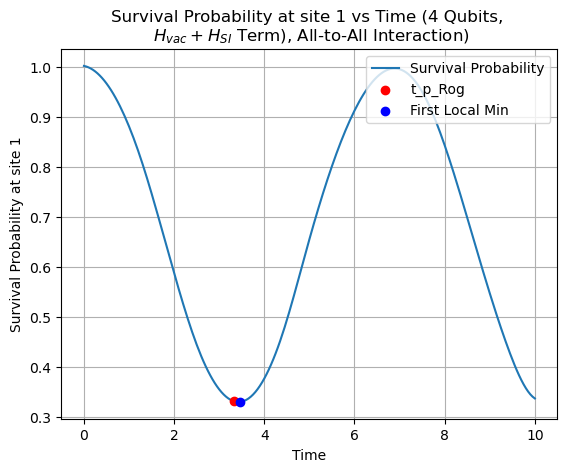

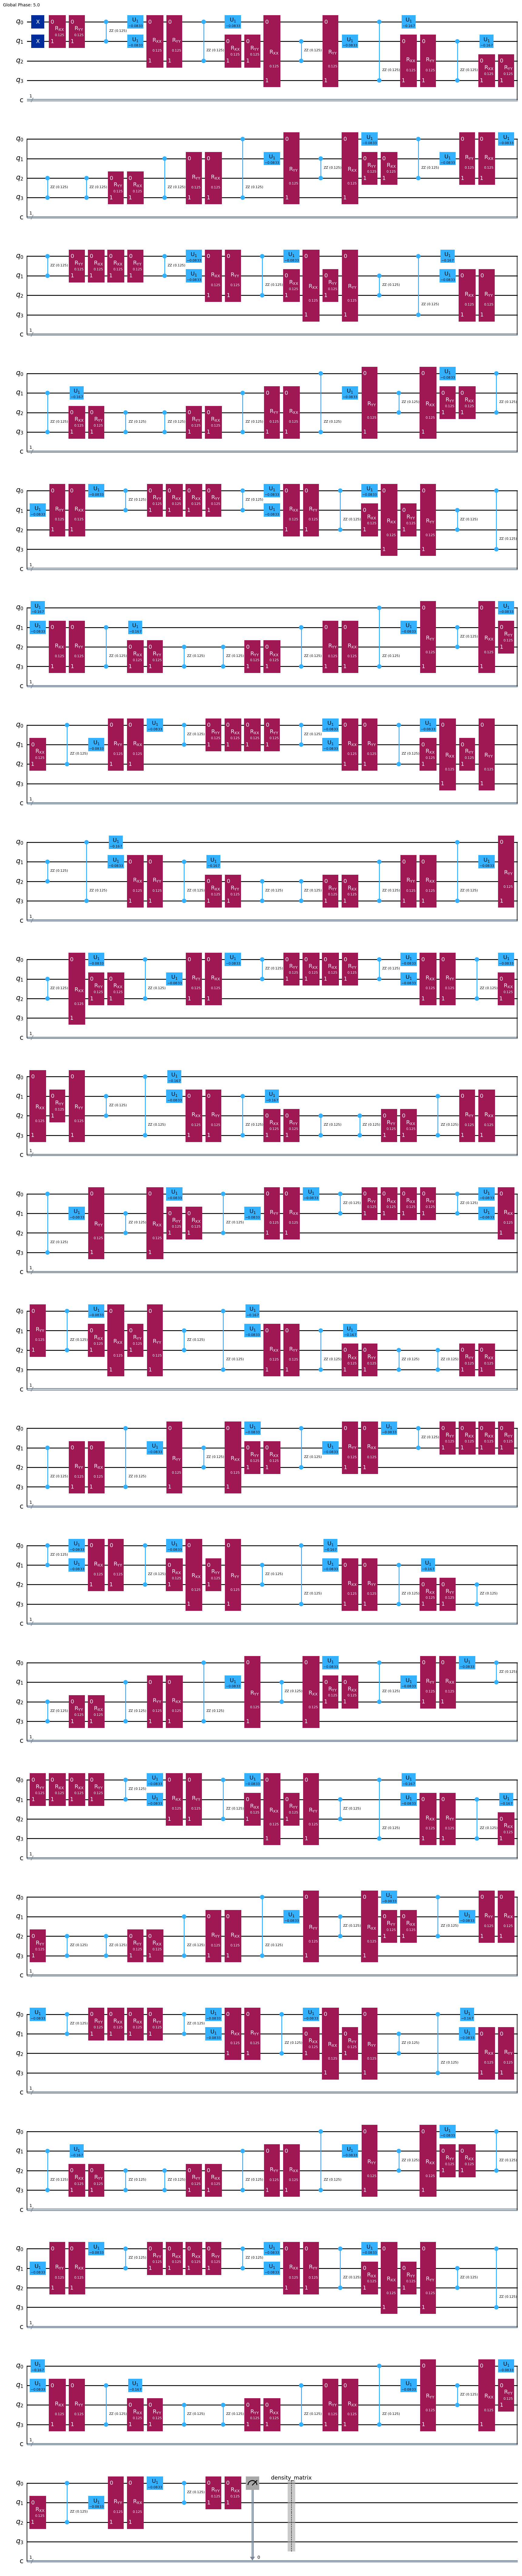

In [12]:
N_sites, theta_nu, omega, B, N, x, p, energy_sign, Δx, Δp, L, delta_m_squared, shape_name , shots, trotter_steps, backend, tolerance, τ, times, ttotal, optimization_level= initialize_parameters()
sigma_z_values, survival_probabilities, t_min, t_p_Rog, i_first_local_min, circuit =  simulate(times, omega, N_sites, theta_nu, backend, shots, τ, ttotal,optimization_level,N, B, Δx, p, tolerance, trotter_steps, trotter_order)
plot_results(times,shots, sigma_z_values, survival_probabilities, N_sites, ttotal, t_min, t_p_Rog, i_first_local_min)
circuit.draw(output="mpl")